In [36]:
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision

In [37]:
def show_img(image,num_images=25,size=(1,28,28)):
    img = image.detach().cpu().view(-1,*size)
    img_grid = torchvision.utils.make_grid(img[:num_images],nrow=5)
    plt.imshow(img_grid.permute(1,2,0).squeeze())
    plt.show()

In [38]:
trans = torchvision.transforms.ToTensor()

In [39]:
dataloader=torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST('.',download=True,transform=trans),batch_size=128,shuffle=True)

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


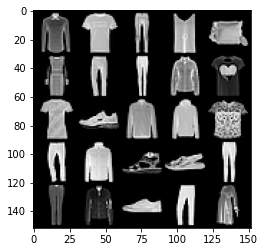

In [40]:
for img,label in dataloader:
    show_img(img)
    break

In [41]:
class Generator(nn.Module):
    def __init__(self, z_dim=10,im_dim=784,hidden_dim=128):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            self.make_gen_block(z_dim,hidden_dim),
            self.make_gen_block(hidden_dim,hidden_dim*2),
            self.make_gen_block(hidden_dim*2,hidden_dim*4),
            self.make_gen_block(hidden_dim*4,hidden_dim*8),
            self.make_gen_block(hidden_dim*8,im_dim,last=True)
        )
    def make_gen_block(self,input_dim,output_dim,last=False):
        if not last:
            seq_layer = nn.Sequential(
            nn.Linear(input_dim,output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU(inplace=True)
        )
        else:
            seq_layer = nn.Sequential(
                nn.Linear(input_dim,output_dim),
                nn.Sigmoid()
            )
        return seq_layer
    def forward(self,x):
        return self.layer(x)

In [42]:
# def test_gen_reasonable(num_images=10):
#     # Don't use explicit casts to cuda - use the device argument
#     import inspect, re
#     lines = inspect.getsource(cal_gen_loss)
#     assert (re.search(r"to\(.cuda.\)", lines)) is None
#     assert (re.search(r"\.cuda\(\)", lines)) is None
    
#     z_dim = 64
#     gen = torch.zeros_like
#     disc = nn.Identity()
#     criterion = torch.mul # Multiply
#     gen_loss_tensor = cal_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
#     assert torch.all(torch.abs(gen_loss_tensor) < 1e-5)
#     #Verify shape. Related to gen_noise parametrization
#     assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)

#     gen = torch.ones_like
#     disc = nn.Identity()
#     criterion = torch.mul # Multiply
#     real = torch.zeros(num_images, 1)
#     gen_loss_tensor = cal_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
#     assert torch.all(torch.abs(gen_loss_tensor - 1) < 1e-5)
#     #Verify shape. Related to gen_noise parametrization
#     assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)
    

# def test_gen_loss(num_images):
#     z_dim = 64
#     gen = Generator(z_dim).to(device)
#     gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
#     disc = Discriminator().to(device) 
#     disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    
#     gen_loss = cal_gen_loss(gen, disc, criterion, num_images, z_dim, device)
    
#     # Check that the loss is reasonable
#     assert (gen_loss - 0.7).abs() < 0.1
#     gen_loss.backward()
#     old_weight = gen.layer[0][0].weight.clone()
#     gen_opt.step()
#     new_weight = gen.layer[0][0].weight
#     assert not torch.all(torch.eq(old_weight, new_weight))


# test_gen_reasonable(10)
# test_gen_loss(18)
# print("Success!")

In [43]:
def noise_generator(batch_size, z_dim, device='cpu'):
    return torch.randn((batch_size,z_dim),device=device)

In [44]:
class Discriminator(nn.Module):
    def __init__(self,im_dim=784,hidden_dim=128):
        super(Discriminator,self).__init__()
        self.layer = nn.Sequential(
            self.make_disc_block(im_dim,hidden_dim*4),
            self.make_disc_block(hidden_dim*4,hidden_dim*2),
            self.make_disc_block(hidden_dim*2,hidden_dim),
            self.make_disc_block(hidden_dim,1,last=True)
        )
        
    def forward(self,x):
        x = self.layer(x)
        return x
    
    def make_disc_block(self,input_dim,output_dim,last=False):
        if not last:
            seq_layer = nn.Sequential(
                nn.Linear(input_dim,output_dim),
#                 nn.BatchNorm1d(output_dim),
                nn.LeakyReLU(0.2))
        else:
            seq_layer = nn.Sequential(
                nn.Linear(input_dim,output_dim)
            )
        return seq_layer

In [45]:
def cal_gen_loss(gen,disc,criterion,num_images,z_dim,device='cpu'):
    noise = noise_generator(num_images,z_dim=z_dim,device=device)
    pred = disc(gen(noise))
    gen_loss = criterion(pred,torch.ones_like(pred))
    return gen_loss

def cal_disc_loss(gen,disc,criterion,real_img,num_images,z_dim,device='cpu'):
    noise = noise_generator(num_images,z_dim=z_dim,device=device)
    fake_image = gen(noise).detach()
    disc_fake_pred = disc(fake_image)
    disc_fake_loss = criterion(disc_fake_pred,torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real_img)
    disc_real_loss = criterion(disc_real_pred,torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

In [46]:
# device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
print(torch.cuda.get_device_name(device))
print(device)

Available devices  1
Current cuda device  0
Tesla P100-PCIE-16GB
cuda


In [47]:
gen = Generator(z_dim=64,im_dim=28*28).to(device)
gen_optimizer = torch.optim.Adam(gen.parameters(),lr = 0.00001)
disc = Discriminator().to(device) 
disc_optimizer = torch.optim.Adam(disc.parameters(),lr = 0.00001)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128

cur_step = 0
mean_gen_loss = 0
mean_disc_loss = 0

for epoch in range(n_epochs):
    for real,_ in dataloader:
        cur_batch_size = len(real)
        real = real.view(cur_batch_size,-1).to(device)

        disc_optimizer.zero_grad()
        disc_loss = cal_disc_loss(gen,disc,criterion,real,cur_batch_size,z_dim,device)
        disc_loss.backward(retain_graph=True)
        disc_optimizer.step()

        gen_optimizer.zero_grad()
        gen_loss = cal_gen_loss(gen,disc,criterion,cur_batch_size,z_dim,device)
        gen_loss.backward()
        gen_optimizer.step()

        mean_disc_loss += disc_loss.item() / display_step
        mean_gen_loss += gen_loss.item() / display_step
        
        if cur_step % display_step == 0 and cur_step:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_gen_loss}, Discriminator loss: {mean_disc_loss}")
            noise = noise_generator(cur_batch_size,z_dim,device)
            gen_img = gen(noise)
            show_img(gen_img)
            show_img(real)
            mean_disc_loss, mean_gen_loss = 0, 0
        cur_step +=1 
            